# Train a Baseline

<!--- @wandbcode{sagemaker-studio-lab} -->

The model is supposed to learn a per-pixel annotation of a scene captured from the point of view of the autonomous agent. The model needs to categorize or segment each pixel of a given scene into 32 relevant categories such as road, pedestrian, sidewalk, cars etc. like listed below. You can click on any of the segmented images on the table shown above and access this interactive interface for accessing the segmentation result and categories.

![](images/camvid_mask.gif)

For the baseline experiments we decided to use a simple architecture inspired by the `UNet` with a `ResNet50`, `VGG19` and `MobileNetV2` backbone which in-spite being quite easy to implement is also quite robust with respect to its performance. We also incorporated the Chained Residual Pooling Layer as proposed by the creators of the RefineNet architecture, so that our model is able to capture background context from a large image region by efficiently pooling features with multiple window sizes and fusing them together with residual connections and learnable weights. 

We performed the baseline experiments with `Focal Loss`. We attach a brief summary of our experiments with the baseline models and the loss functions.

> We will need a `GPU` backend for this notebooks, we can check using `nvidia-smi` command like this

In [ ]:
!nvidia-smi

In [23]:
import wandb
import torch
import timm
from fastai.vision.all import *
from typing import List, Union, Tuple
from fastai.callback.wandb import WandbCallback

from segmentation.metrics import dice_per_class, faccuracy
from segmentation.model import SegmentationModel

we will define some parameters to pass to our config and baseline

In [3]:
# wandb params
PROJECT="sagemaker_camvid_demo"
ENTITY=None

# hyper params
IMAGE_SHAPE = (720, 960)

BACKBONE = "resnet34d"
SEED = 42

RUN_NAME = f"final-fit-{BACKBONE}"
JOB_TYPE = "train"

ARTIFACT_ID = "camvid-dataset:latest"

BATCH_SIZE = 8
IMAGE_RESIZE_FACTOR = 2
VALIDATION_SPLIT_PCT = 0.2
HIDDEN_DIM = 256


LEARNING_RATE = 0.00065
TRAIN_EPOCHS = 15
WEIGHT_DECAY = 0.01
USE_AUGMENTATION = True

INFERENCE_BATCH_SIZE = 4
NUM_WARMUP_ITERS = 10
NUM_INFERENCE_BENCHMARK_ITERS = 100

> In `train.py` you can see a best-practices refactor of this training notebook using `ml_collecions` to handle configs.

In [4]:
set_seed(SEED)

In [5]:
wandb.init(
    project=PROJECT,
    name=RUN_NAME,
    entity=ENTITY,
    job_type=JOB_TYPE,
    config={
        "artifact_id": ARTIFACT_ID,
        "image_shape": IMAGE_SHAPE,
        "batch_size": BATCH_SIZE,
        "image_resize_factor": IMAGE_RESIZE_FACTOR,
        "validation_split": VALIDATION_SPLIT_PCT,
        "hidden_dims": HIDDEN_DIM,
        "backbone": BACKBONE,
        "learning_rate": LEARNING_RATE,
        "train_epochs": TRAIN_EPOCHS,
        "inference_batch_size": INFERENCE_BATCH_SIZE,
        "num_warmup_iters": NUM_WARMUP_ITERS,
        "num_inference_banchmark_iters": NUM_INFERENCE_BENCHMARK_ITERS,
        "augmentations":USE_AUGMENTATION,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


## DataLoader for SegmentationDataLoader for Segmentation

In [6]:
def label_func(fn):
    return fn.parent.parent/"labels"/f"{fn.stem}_P{fn.suffix}"


def get_dataloaders(
    artifact_id: str, # the name of the artifact
    batch_size: int,  # the batch size for training, 2x for val
    resize_factor: int, # a integer resize factor for training
    validation_split_pct: float, # the validation percentage of data to be used in [0,1] 
    augment: bool, # use augmentations
    seed: int, # the seed
):
    """Grab an artifact and creating a Pytorch DataLoader"""
    artifact = wandb.use_artifact(artifact_id, type='dataset')
    artifact_dir = Path(artifact.download())
    codes = np.loadtxt(artifact_dir/'codes.txt', dtype=str)
    fnames = get_image_files(artifact_dir/"images")
    class_labels = {k: v for k, v in enumerate(codes)}
    
    image_shape = load_image(fnames[0]).shape
    
    tfms = aug_transforms()
    
    return SegmentationDataLoaders.from_label_func(
        artifact_dir,
        bs=batch_size,
        fnames=fnames,
        label_func=label_func,
        codes=codes,
        item_tfms=Resize((
            image_shape[0] // resize_factor,
            image_shape[1] // resize_factor
        )),
        batch_tfms=tfms if augment else None,
        valid_pct=validation_split_pct,
        seed=seed
    ), class_labels

wandb: Downloading large artifact camvid-dataset:latest, 572.51MB. 1405 files... Done. 0:0:0


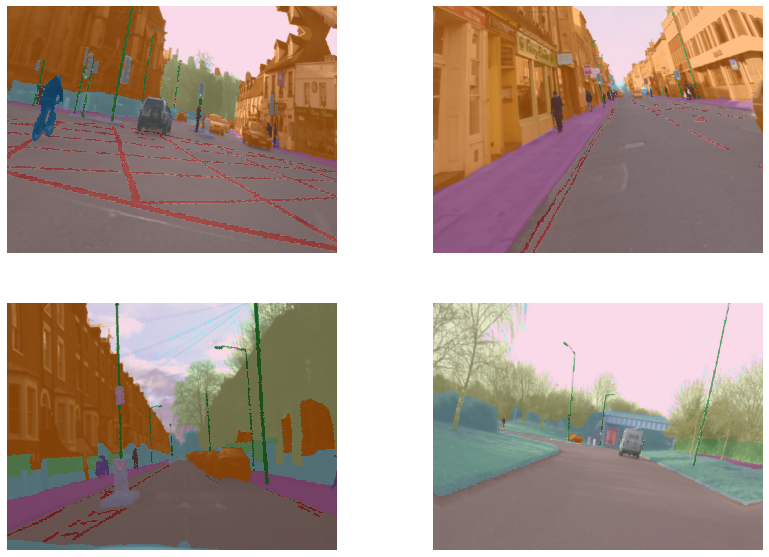

In [7]:
data_loader, class_labels = get_dataloaders(
    artifact_id=ARTIFACT_ID,
    batch_size=BATCH_SIZE,
    resize_factor=IMAGE_RESIZE_FACTOR,
    validation_split_pct=VALIDATION_SPLIT_PCT,
    augment=USE_AUGMENTATION,
    seed=SEED
)

data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Training and Inference

Let's log a bunch of useful data for model evaluation

In [8]:
def get_learner(
    data_loader,
    backbone: str,
    hidden_dim: int,
    num_classes: int,
    checkpoint_file: Union[None, str, Path],
    loss_func,
    metrics: List,
    log_preds: bool = False
):
    model = SegmentationModel(backbone, hidden_dim, num_classes=num_classes)
    mixed_precision_callback = MixedPrecision()
    wandb_callback = WandbCallback(log_model=False, log_preds=log_preds)
    learner = Learner(
        data_loader,
        model,
        loss_func=loss_func,
        metrics=metrics,
        cbs=[mixed_precision_callback, wandb_callback],
    )
    if checkpoint_file is not None:
        load_model(checkpoint_file, learner.model, opt=None, with_opt=False)
        # learner.load(checkpoint_file)
    return learner

In [9]:
learn = get_learner(
    data_loader,
    backbone=BACKBONE,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(class_labels),
    checkpoint_file=None,
    loss_func=FocalLossFlat(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    log_preds=False,
)

In [10]:
learn.fit_one_cycle(TRAIN_EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,2.103063,1.114405,0.117595,0.715503,00:26
1,0.943291,0.487060,0.227620,0.826380,00:20
2,0.519839,0.379037,0.323198,0.843909,00:20
3,0.344815,0.334862,0.336946,0.841742,00:20
4,0.271333,0.226404,0.448113,0.881910,00:20
5,0.216837,0.216458,0.468167,0.881620,00:20
6,0.188914,0.195984,0.495132,0.888481,00:21
7,0.162792,0.165584,0.526064,0.903853,00:20
8,0.147955,0.163829,0.542209,0.902554,00:20
9,0.134263,0.139845,0.570809,0.910110,00:20


In [11]:
# if accuracy is greater than 90% send an alert
accuracy_value = learn.recorder.metrics[1].value
if accuracy_value > .90:
    wandb.alert(title=f"Training Succesuful: accuracy={accuracy_value:.3f}", 
                text=f"After {TRAIN_EPOCHS}: run: {wandb.run.name} epochs succesuful")

## Log preds

We want to monitor our model predictions, so let's create a `wandb.Table` containing the labels and predictions side by side, we will also add the dice coefficient per class, this way we get a measure of how good the model is performing on each class. We will put value -1 if there is no pixels of that class.
> This enable filtering on the wandb workspace later on.

In [12]:
def _create_row(sample, pred_label, prediction, class_labels):
    """"A simple function to create a row of (img, target, prediction, and scores...)"""
    (image, label) = sample
    # compute metrics
    dice_scores = dice_per_class(prediction, label)
    facc = faccuracy(prediction, label)
    image = image.permute(1, 2, 0)
    row =[
            wandb.Image(image),
            wandb.Image(
                image,
                masks={
                    "predictions": {
                        "mask_data": pred_label[0].numpy(),
                        "class_labels": class_labels,
                    }
                },
            ),
            wandb.Image(
                image,
                masks={
                    "ground_truths": {
                        "mask_data": label.numpy(),
                        "class_labels": class_labels,
                    }
                },
            ),
            *dice_scores,
            facc,
    ]
    return row

In [13]:
def create_dice_table(samples, outputs, predictions, class_labels):
    "Creates a wandb table with predictions and targets side by side"

    def _to_str(l):
        return [str(x) for x in l]
    
    items = list(zip(samples, outputs, predictions))

    # we create one row per sample
    data = []
    for item in progress_bar(items):
        data.append(_create_row(*item, class_labels=class_labels))
    
    table = wandb.Table(
        data=data,
        columns=["Image", "Predicted_Mask", "Ground_Truth"]
        + _to_str(class_labels.values())
        + ["Foreground Acc"],
    )
    return table

In [17]:
def get_predictions(learner, test_dl=None, max_n=None):
    """Return the samples = (x,y) and outputs (model predictions decoded), and predictions (raw preds)"""
    test_dl = learner.dls.valid if test_dl is None else test_dl
    inputs, predictions, targets, outputs = learner.get_preds(
        dl=test_dl, with_input=True, with_decoded=True
    )
    x, y, samples, outputs = learner.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=max_n
    )
    return samples, outputs, predictions

In [18]:
def table_from_dl(learn, test_dl, class_labels):
    samples, outputs, predictions = get_predictions(learn, test_dl)
    table = create_dice_table(samples, outputs, predictions, class_labels)
    return table

We will create the prediction table and log it to the workspace (this takes around 3 minutes)

In [24]:
pred_table = table_from_dl(learn, learn.dls.valid, class_labels)

In [25]:
wandb.log({f"Predictions_Table": pred_table})

## Save models

Let's keep track of our trained models

In [27]:
def save_model_to_artifacts(
    model,
    model_name: str,
    image_shape: Tuple[int, int],
    artifact_name: str,
    metadata: Dict,
):
    print("Saving model checkpoint")
    torch.save(model, model_name + ".pth")

    print("Saving model using scripting...")
    saved_model_script = torch.jit.script(model)
    saved_model_script.save(model_name + "_script.pt")

    print("Done!!!")
    example_forward_input = torch.randn(
        1, 3, image_shape[0] // 2, image_shape[0] // 2, dtype=torch.float
    ).to("cuda")
    print("Saving model using tracing...")
    saved_model_traced = torch.jit.trace(model, example_inputs=example_forward_input)
    saved_model_traced.save(model_name + "_traced.pt")
    print("Done!!!")

In [30]:
save_model_to_artifacts(
    learn.model, 
    f"Unet_{BACKBONE}", 
    image_shape=IMAGE_SHAPE,
    artifact_name=f"{wandb.run.name}-saved-model",
    metadata={
        "backbone": BACKBONE,
        "hidden_dims": HIDDEN_DIM,
        "input_size": IMAGE_SHAPE,
        "class_labels": class_labels
    }
)

Saving model checkpoint
Saving model using scripting...
Done!!!
Saving model using tracing...
Done!!!


In [31]:
wandb.finish()

dice_multi,▁▃▄▄▆▆▆▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,▁▅▅▅▇▇▇▇▇██████
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
